In [1]:
import os, random, json, math, time
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, roc_curve, auc)
from sklearn.preprocessing import label_binarize
import pandas as pd
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch:", torch.__version__, "CUDA:", torch.cuda.is_available())

E:\hw2\venv\Lib\site-packages\albumentations\check_version.py:147: UserWarning: Error fetching version info <urlopen error _ssl.c:1001: The handshake operation timed out>
  data = fetch_version_info()


PyTorch: 2.9.1+cu130 CUDA: True


In [2]:
CLASSES = ['cat', 'dog', 'bird', 'car', 'bicycle']
NUM_CLASSES = len(CLASSES)

OBJECTS_DIR = Path("data//objects")
BACKGROUNDS_DIR = Path("data//backgrounds")
OUTPUT_DIR = Path("dataset")
IMAGE_SIZE = (512, 512)

DATASET_SPLITS = {'train': 700, 'validation': 150, 'test': 150}  # на класс
BATCH_SIZE = 32
EPOCHS = 30
LR = 1e-3

print("Classes:", CLASSES)
print("Image size:", IMAGE_SIZE)
print("Splits (per class):", DATASET_SPLITS)

Classes: ['cat', 'dog', 'bird', 'car', 'bicycle']
Image size: (512, 512)
Splits (per class): {'train': 700, 'validation': 150, 'test': 150}


In [3]:
class SyntheticDataGenerator:
    def __init__(self, objects_dir, backgrounds_dir, output_dir, image_size=(224, 224)):
        self.objects_dir = Path(objects_dir)
        self.backgrounds_dir = Path(backgrounds_dir)
        self.output_dir = Path(output_dir)
        self.image_size = image_size
        self.objects_by_class = self._load_objects()
        self.backgrounds = self._load_backgrounds()
        self.final_aug = A.Compose([
            A.RandomBrightnessContrast(0.3, 0.3, p=0.7),
            A.GaussianBlur(blur_limit=(3,5), p=0.3),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            A.HueSaturationValue(20, 30, 20, p=0.5),
        ])
    
    def _load_objects(self):
        d = {}
        for class_dir in self.objects_dir.iterdir():
            if class_dir.is_dir():
                imgs = []
                for p in class_dir.glob("*.png"):
                    img = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
                    if img is not None and img.shape[2] == 4:
                        imgs.append(img)
                if imgs:
                    d[class_dir.name] = imgs
                    print(f"Loaded {len(imgs)} objects for {class_dir.name}")
        return d
    
    def _load_backgrounds(self):
        bgs = []
        for p in self.backgrounds_dir.glob("*.*"):
            if p.suffix.lower() in [".jpg",".jpeg",".png"]:
                img = cv2.imread(str(p))
                if img is not None:
                    bgs.append(img)
        print(f"Loaded {len(bgs)} backgrounds")
        return bgs
    
    def _rotate(self, img, angle):
        h, w = img.shape[:2]
        center = (w//2, h//2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        cos, sin = abs(M[0,0]), abs(M[0,1])
        nw, nh = int((h*sin)+(w*cos)), int((h*cos)+(w*sin))
        M[0,2] += (nw/2) - center[0]
        M[1,2] += (nh/2) - center[1]
        return cv2.warpAffine(img, M, (nw, nh), borderValue=(0,0,0,0))
    
    def _resize_ar(self, img, target):
        h, w = img.shape[:2]
        scale = min(target[0]/w, target[1]/h)
        return cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    
    def _overlay(self, bg, obj, pos):
        x, y = pos
        h, w = obj.shape[:2]
        if x < 0 or y < 0 or x+w > bg.shape[1] or y+h > bg.shape[0]:
            x0, y0 = max(0,x), max(0,y)
            x1, y1 = min(bg.shape[1], x+w), min(bg.shape[0], y+h)
            ox0, oy0 = x0 - x, y0 - y
            ox1, oy1 = ox0 + (x1 - x0), oy0 + (y1 - y0)
            obj = obj[oy0:oy1, ox0:ox1]
            x, y, h, w = x0, y0, obj.shape[0], obj.shape[1]
        if h <=0 or w <=0: return bg
        if obj.shape[2] == 4:
            alpha = obj[:,:,3]/255.0
            obj_rgb = obj[:,:,:3]
        else:
            alpha = np.ones((h,w))
            obj_rgb = obj
        roi = bg[y:y+h, x:x+w]
        for c in range(3):
            roi[:,:,c] = roi[:,:,c]*(1-alpha) + obj_rgb[:,:,c]*alpha
        bg[y:y+h, x:x+w] = roi
        return bg
    
    def generate_image(self, obj_img, bg_img):
        bg = cv2.resize(bg_img.copy(), self.image_size, interpolation=cv2.INTER_AREA)
        obj = obj_img.copy()
        obj = self._rotate(obj, random.randint(-30,30))
        if random.random() > 0.5:
            obj = cv2.flip(obj, 1)
        scale = random.uniform(0.3, 0.7)
        obj = self._resize_ar(obj, (int(self.image_size[0]*scale), int(self.image_size[1]*scale)))
        oh, ow = obj.shape[:2]
        max_x = max(0, self.image_size[0]-ow)
        max_y = max(0, self.image_size[1]-oh)
        x = random.randint(0, max_x) if max_x>0 else 0
        y = random.randint(0, max_y) if max_y>0 else 0
        res = self._overlay(bg, obj, (x,y))
        res = self.final_aug(image=res)["image"]
        return res
    
    def generate_dataset(self, splits, image_size=(224,224)):
        self.image_size = image_size
        for split, count in splits.items():
            print(f"\n=== Generating {split} ===")
            for cls, objs in self.objects_by_class.items():
                out_dir = self.output_dir / split / cls
                out_dir.mkdir(parents=True, exist_ok=True)
                for i in range(count):
                    obj = random.choice(objs)
                    bg = random.choice(self.backgrounds)
                    img = self.generate_image(obj, bg)
                    cv2.imwrite(str(out_dir/f"{cls}_{split}_{i:04d}.jpg"), img)
                    if (i+1)%100==0:
                        print(f"  {cls}: {i+1}/{count}")
                print(f"✓ {cls}: {count} images")

Loaded 15 objects for bicycles
Loaded 15 objects for birds
Loaded 15 objects for cars
Loaded 16 objects for cats
Loaded 15 objects for dogs
Loaded 23 backgrounds


C:\Users\Pavel\AppData\Local\Temp\ipykernel_14340\4259224208.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


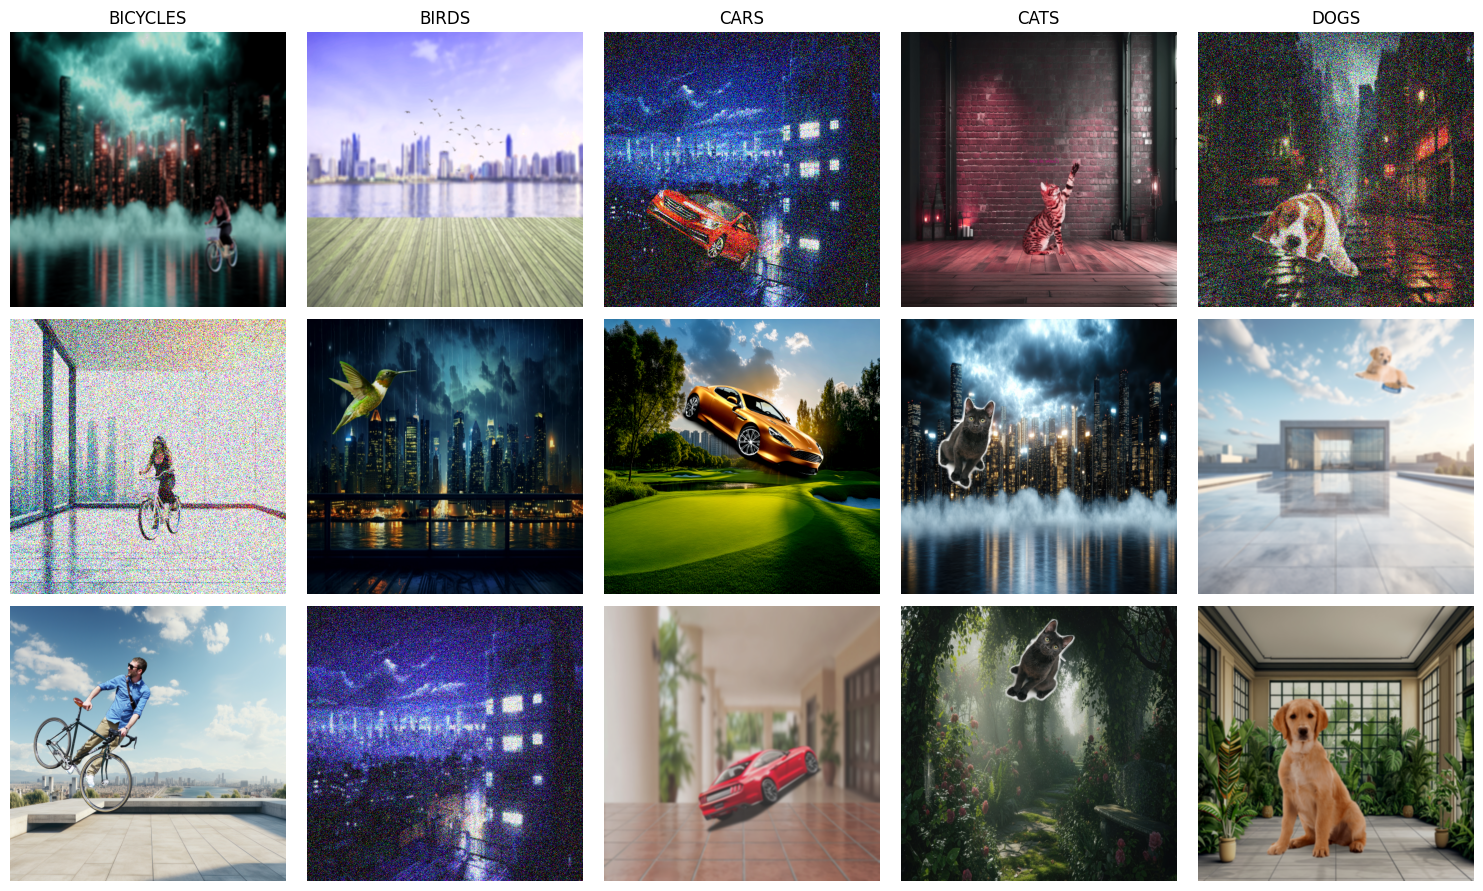

In [4]:
generator = SyntheticDataGenerator(OBJECTS_DIR, BACKGROUNDS_DIR, OUTPUT_DIR, IMAGE_SIZE)

# Примеры (5 на класс)
def show_examples(gen, n=3):
    fig, axes = plt.subplots(n, len(gen.objects_by_class), figsize=(len(gen.objects_by_class)*3, n*3))
    for c, cls in enumerate(gen.objects_by_class.keys()):
        for r in range(n):
            obj = random.choice(gen.objects_by_class[cls])
            bg = random.choice(gen.backgrounds)
            img = gen.generate_image(obj, bg)
            axes[r,c].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[r,c].axis('off')
            if r==0: axes[r,c].set_title(cls.upper())
    plt.tight_layout()
    plt.show()

show_examples(generator, n=3)

In [5]:
generator.generate_dataset(DATASET_SPLITS, IMAGE_SIZE)
print("✅ Dataset ready at", OUTPUT_DIR)


=== Generating train ===
  bicycles: 100/700
  bicycles: 200/700
  bicycles: 300/700
  bicycles: 400/700
  bicycles: 500/700
  bicycles: 600/700
  bicycles: 700/700
✓ bicycles: 700 images
  birds: 100/700
  birds: 200/700
  birds: 300/700
  birds: 400/700
  birds: 500/700
  birds: 600/700
  birds: 700/700
✓ birds: 700 images
  cars: 100/700
  cars: 200/700
  cars: 300/700
  cars: 400/700
  cars: 500/700
  cars: 600/700
  cars: 700/700
✓ cars: 700 images
  cats: 100/700
  cats: 200/700
  cats: 300/700
  cats: 400/700
  cats: 500/700
  cats: 600/700
  cats: 700/700
✓ cats: 700 images
  dogs: 100/700
  dogs: 200/700
  dogs: 300/700
  dogs: 400/700
  dogs: 500/700
  dogs: 600/700
  dogs: 700/700
✓ dogs: 700 images

=== Generating validation ===
  bicycles: 100/150
✓ bicycles: 150 images
  birds: 100/150
✓ birds: 150 images
  cars: 100/150
✓ cars: 150 images
  cats: 100/150
✓ cats: 150 images
  dogs: 100/150
✓ dogs: 150 images

=== Generating test ===
  bicycles: 100/150
✓ bicycles: 150 im

In [6]:
def dataset_stats(root):
    root = Path(root)
    rows = []
    total = 0
    for split in ["train","validation","test"]:
        split_dir = root/split
        if not split_dir.exists(): continue
        counts = {}
        split_total = 0
        for cls_dir in split_dir.iterdir():
            if cls_dir.is_dir():
                c = len(list(cls_dir.glob("*.jpg")))
                counts[cls_dir.name] = c
                split_total += c
        counts["TOTAL"] = split_total
        total += split_total
        rows.append({"Split": split, **counts})
    return rows, total

rows, total_imgs = dataset_stats(OUTPUT_DIR)
df_stats = pd.DataFrame(rows)
print(df_stats)
print("\nTotal images:", total_imgs)

        Split  bicycles  birds  cars  cats  dogs  TOTAL
0       train       700    700   700   700   700   3500
1  validation       150    150   150   150   150    750
2        test       150    150   150   150   150    750

Total images: 5000


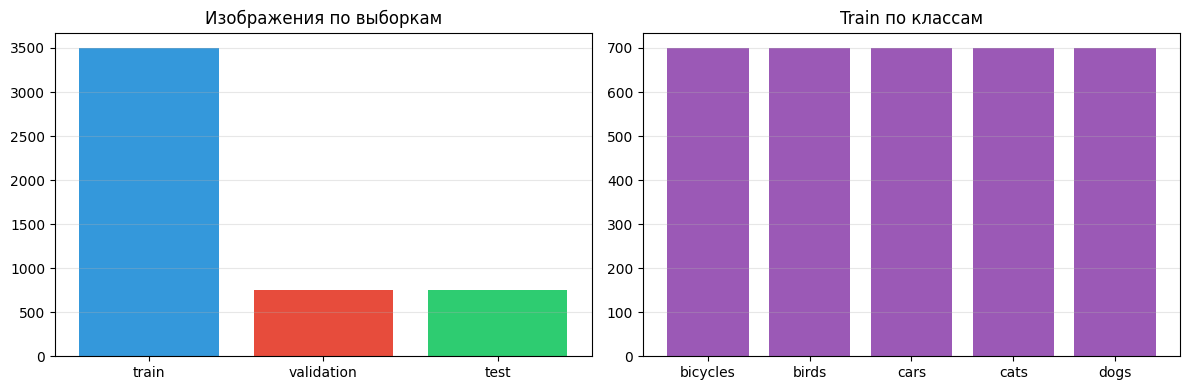

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].bar(df_stats["Split"], df_stats["TOTAL"], color=["#3498db","#e74c3c","#2ecc71"])
ax[0].set_title("Изображения по выборкам")
ax[0].grid(axis="y", alpha=0.3)

train_classes = {k:v for k,v in rows[0].items() if k not in ["Split","TOTAL"]}
ax[1].bar(train_classes.keys(), train_classes.values(), color="#9b59b6")
ax[1].set_title("Train по классам")
ax[1].grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
train_tfms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
test_tfms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = ImageFolder(OUTPUT_DIR/"train", transform=train_tfms)
val_ds   = ImageFolder(OUTPUT_DIR/"validation", transform=test_tfms)
test_ds  = ImageFolder(OUTPUT_DIR/"test", transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

class_names = train_ds.classes
print("Classes:", class_names)
print("Train/Val/Test:", len(train_ds), len(val_ds), len(test_ds))

Classes: ['bicycles', 'birds', 'cars', 'cats', 'dogs']
Train/Val/Test: 3500 750 750


In [9]:
def create_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    for p in model.parameters():
        p.requires_grad = False
    # разморозим последний блок для тонкой настройки
    for p in list(model.layer4.parameters()):
        p.requires_grad = True
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

model = create_model(NUM_CLASSES).to(device)

In [10]:
hyperparams = pd.DataFrame({
    "Параметр":[
        "Оптимизатор","Learning rate","Функция потерь",
        "Batch size","Epochs","Callbacks (ручные)"
    ],
    "Значение":[
        "Adam (только head + layer4)",
        LR,
        "CrossEntropyLoss",
        BATCH_SIZE,
        EPOCHS,
        "Early stopping (val loss, patience=5), LR decay (plateau x0.5)"
    ],
    "Обоснование":[
        "Быстрая сходимость, адаптивный шаг; замороженные ранние слои",
        "Базовое стабильное значение для Adam",
        "Многоклассовая классификация с integer-метками",
        "Баланс скорость/стабильность градиента",
        "Достаточно при early stopping",
        "Контроль переобучения и адаптация learning rate"
    ]
})
hyperparams

Параметр                                           Значение  \
0         Оптимизатор                        Adam (только head + layer4)   
1       Learning rate                                              0.001   
2      Функция потерь                                   CrossEntropyLoss   
3          Batch size                                                 32   
4              Epochs                                                 30   
5  Callbacks (ручные)  Early stopping (val loss, patience=5), LR deca...   

                                         Обоснование  
0  Быстрая сходимость, адаптивный шаг; замороженн...  
1               Базовое стабильное значение для Adam  
2     Многоклассовая классификация с integer-метками  
3             Баланс скорость/стабильность градиента  
4                      Достаточно при early stopping  
5    Контроль переобучения и адаптация learning rate

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, n = 0,0,0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        pred = logits.argmax(1)
        correct += (pred == labels).sum().item()
        n += imgs.size(0)
    return total_loss/n, correct/n

def eval_epoch(model, loader):
    model.eval()
    total_loss, correct, n = 0,0,0
    all_logits, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            total_loss += loss.item() * imgs.size(0)
            pred = logits.argmax(1)
            correct += (pred == labels).sum().item()
            n += imgs.size(0)
            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)
    return total_loss/n, correct/n, all_logits, all_labels

In [12]:
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "lr":[]}
best_val = 1e9
patience, wait = 5, 0

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)
    scheduler.step(val_loss)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(val_acc)
    history["lr"].append(optimizer.param_groups[0]["lr"])
    
    print(f"Epoch {epoch:02d}: train_loss={tr_loss:.4f} val_loss={val_loss:.4f} "
          f"train_acc={tr_acc:.4f} val_acc={val_acc:.4f} lr={optimizer.param_groups[0]['lr']:.2e}")
    
    # Early stopping
    if val_loss < best_val - 1e-4:
        best_val = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# load best
model.load_state_dict(torch.load("best_model.pth"))

Epoch 01: train_loss=0.4469 val_loss=0.2025 train_acc=0.8483 val_acc=0.9400 lr=1.00e-03
Epoch 02: train_loss=0.1526 val_loss=0.1088 train_acc=0.9523 val_acc=0.9600 lr=1.00e-03
Epoch 03: train_loss=0.1330 val_loss=0.0950 train_acc=0.9589 val_acc=0.9680 lr=1.00e-03
Epoch 04: train_loss=0.0920 val_loss=0.0610 train_acc=0.9731 val_acc=0.9773 lr=1.00e-03
Epoch 05: train_loss=0.0739 val_loss=0.0845 train_acc=0.9774 val_acc=0.9707 lr=1.00e-03
Epoch 06: train_loss=0.0584 val_loss=0.0560 train_acc=0.9811 val_acc=0.9773 lr=1.00e-03
Epoch 07: train_loss=0.0632 val_loss=0.0841 train_acc=0.9797 val_acc=0.9733 lr=1.00e-03
Epoch 08: train_loss=0.0562 val_loss=0.0711 train_acc=0.9831 val_acc=0.9747 lr=1.00e-03
Epoch 09: train_loss=0.0609 val_loss=0.0712 train_acc=0.9817 val_acc=0.9747 lr=1.00e-03
Epoch 10: train_loss=0.0529 val_loss=0.0805 train_acc=0.9837 val_acc=0.9773 lr=5.00e-04
Epoch 11: train_loss=0.0289 val_loss=0.0811 train_acc=0.9926 val_acc=0.9773 lr=5.00e-04
Early stopping triggered.


<All keys matched successfully>

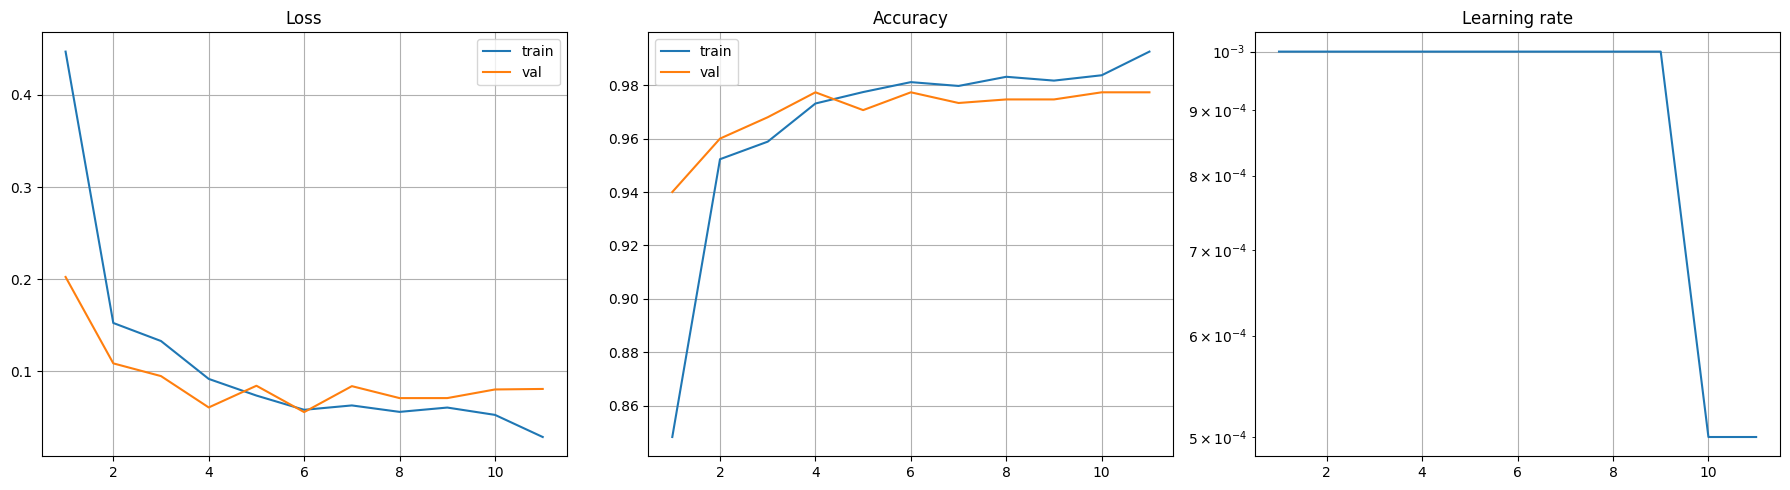

In [13]:
def plot_history(hist):
    epochs = range(1, len(hist["train_loss"])+1)
    fig, axes = plt.subplots(1,3, figsize=(18,5))
    axes[0].plot(epochs, hist["train_loss"], label="train")
    axes[0].plot(epochs, hist["val_loss"], label="val")
    axes[0].set_title("Loss"); axes[0].legend(); axes[0].grid(True)
    axes[1].plot(epochs, hist["train_acc"], label="train")
    axes[1].plot(epochs, hist["val_acc"], label="val")
    axes[1].set_title("Accuracy"); axes[1].legend(); axes[1].grid(True)
    axes[2].plot(epochs, hist["lr"], label="lr")
    axes[2].set_title("Learning rate"); axes[2].set_yscale("log"); axes[2].grid(True)
    plt.tight_layout(); plt.show()

plot_history(history)

In [14]:
test_loss, test_acc, test_logits, test_labels = eval_epoch(model, test_loader)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
y_true = test_labels.numpy()
y_probs = torch.softmax(test_logits, dim=1).numpy()
y_pred = y_probs.argmax(1)

Test loss: 0.0955 | Test acc: 0.9693


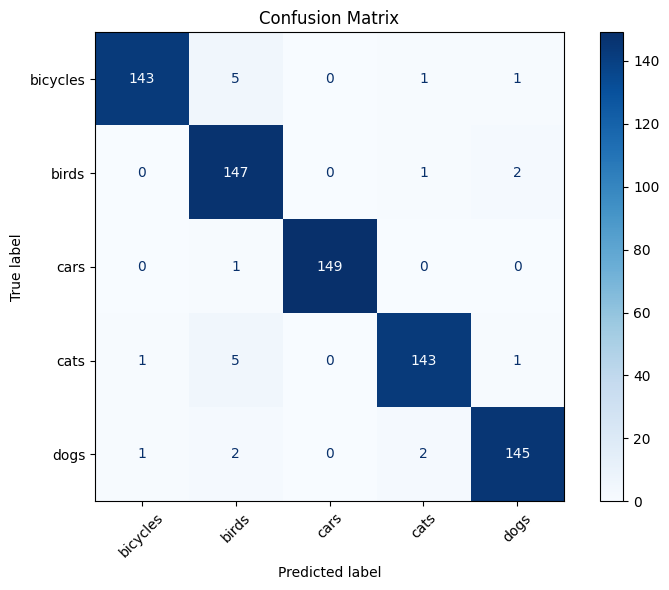

In [15]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

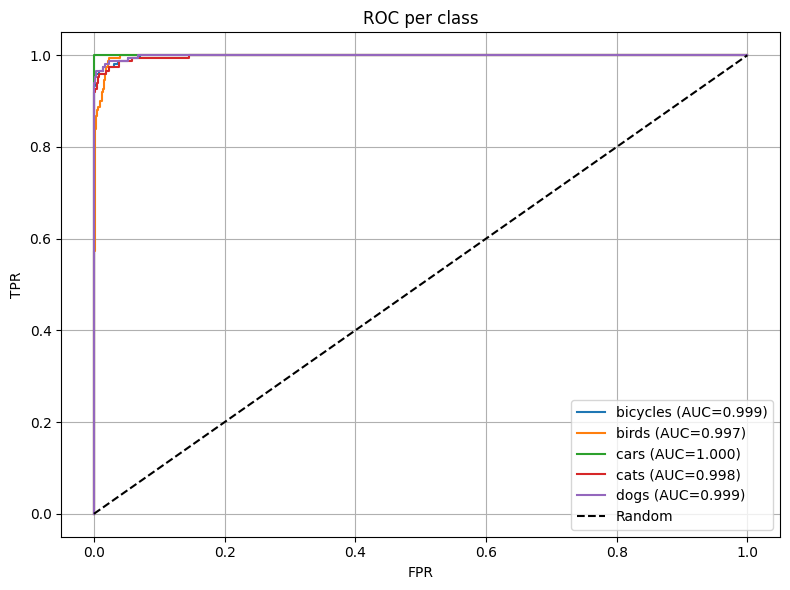

AUC scores: {'bicycles': 0.9985444444444445, 'birds': 0.9974222222222221, 'cars': 1.0, 'cats': 0.9976333333333333, 'dogs': 0.998788888888889}


In [16]:
# ROC per class
y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
plt.figure(figsize=(8,6))
auc_scores = {}
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    auc_scores[cls] = roc_auc
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--',label="Random")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC per class"); plt.legend()
plt.grid(True); plt.tight_layout(); plt.show()
print("AUC scores:", auc_scores)

In [17]:
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

precision    recall  f1-score     support
bicycles       0.986207  0.953333  0.969492  150.000000
birds          0.918750  0.980000  0.948387  150.000000
cars           1.000000  0.993333  0.996656  150.000000
cats           0.972789  0.953333  0.962963  150.000000
dogs           0.973154  0.966667  0.969900  150.000000
accuracy       0.969333  0.969333  0.969333    0.969333
macro avg      0.970180  0.969333  0.969479  750.000000
weighted avg   0.970180  0.969333  0.969479  750.000000

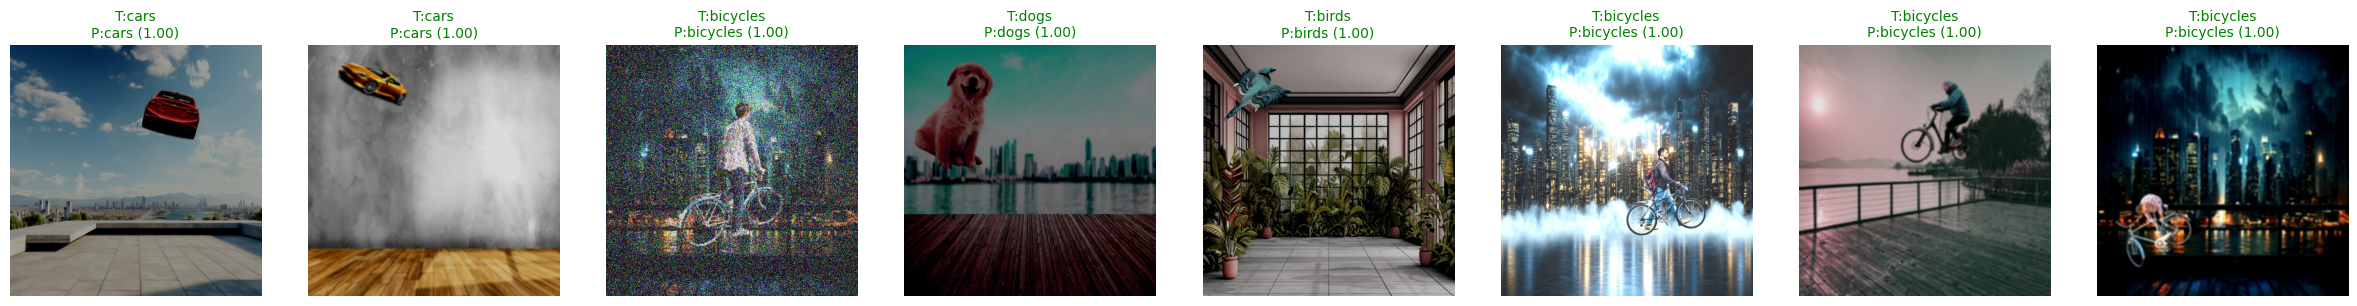

In [18]:
def show_preds(dataset, logits, labels, n=8):
    idxs = list(range(len(dataset)))
    random.shuffle(idxs)
    idxs = idxs[:n]
    fig, axes = plt.subplots(1, n, figsize=(3*n,3))
    for ax, idx in zip(axes, idxs):
        path, true_label = dataset.samples[idx]
        img = plt.imread(path)
        prob = torch.softmax(logits[idx], dim=0)
        pred_label = prob.argmax().item()
        conf = prob[pred_label].item()
        ax.imshow(img)
        color = "green" if pred_label==true_label else "red"
        ax.set_title(f"T:{class_names[true_label]}\nP:{class_names[pred_label]} ({conf:.2f})",
                     color=color, fontsize=10)
        ax.axis('off')
    plt.tight_layout(); plt.show()

show_preds(test_ds, test_logits, test_labels, n=8)